<a href="https://colab.research.google.com/github/Letch49/ML-vvsu-2025-2026/blob/master/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas seaborn scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Домашнее задание 3

1. Выбрать номинальное значение как целевую переменную
2. Провести разведочный анализ **включая** анализ зависимости между номинальными переменными (chi2)
3. Выбрать `best_features`
4. Сделать нормализацию данных (scaler, onehotencoding)
5. Обучить модель логистической регрессии
6. Вывести метрики качества, описать полученный результат (также вывести коэфициенты модели)

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('student_performance.csv')
df

,student_id,weekly_self_study_hours,attendance_percentage,class_participation,total_score,grade
0,1,18.5,95.6,3.8,97.9,A
1,2,14.0,80.0,2.5,83.9,B
2,3,19.5,86.3,5.3,100.0,A
3,4,25.7,70.2,7.0,100.0,A
4,5,13.4,81.9,6.9,92.0,A
...,...,...,...,...,...,...
999995,999996,18.0,95.5,4.8,100.0,A
999996,999997,15.7,82.7,6.7,88.3,A
999997,999998,14.2,85.1,5.8,87.9,A
999998,999999,25.3,90.0,5.3,100.0,A


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   student_id               1000000 non-null  int64  
 1   weekly_self_study_hours  1000000 non-null  float64
 2   attendance_percentage    1000000 non-null  float64
 3   class_participation      1000000 non-null  float64
 4   total_score              1000000 non-null  float64
 5   grade                    1000000 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 45.8+ MB


In [6]:
# 1. Выбрать номинальное значение как целевую переменную

y = df.total_score
df['grade'] = df['grade'].astype('category')
# df.info()
X = df.drop(['student_id', 'total_score', 'grade'], axis=1)
# X.info()
X

,weekly_self_study_hours,attendance_percentage,class_participation
0,18.5,95.6,3.8
1,14.0,80.0,2.5
2,19.5,86.3,5.3
3,25.7,70.2,7.0
4,13.4,81.9,6.9
...,...,...,...
999995,18.0,95.5,4.8
999996,15.7,82.7,6.7
999997,14.2,85.1,5.8
999998,25.3,90.0,5.3


### EDA

In [7]:
# 2. Провести разведочный анализ **включая** анализ зависимости между номинальными переменными (chi2)

mid = df['total_score'].median()
df['score_level'] = df['total_score'].apply(
    lambda x: 'high' if x > mid else 'low'
)
df[['score_level', 'total_score']]

,score_level,total_score
0,high,97.9
1,low,83.9
2,high,100.0
3,high,100.0
4,high,92.0
...,...,...
999995,high,100.0
999996,high,88.3
999997,high,87.9
999998,high,100.0


In [8]:
# 3. Выбрать `best_features`

best_features = ['attendance_percentage', 'weekly_self_study_hours']

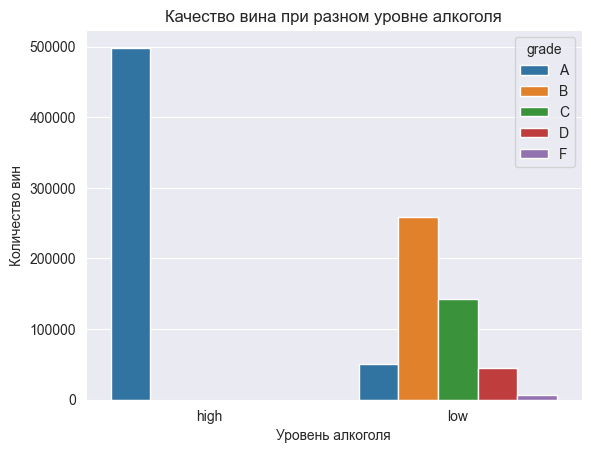

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# визуализируем различия score_level и grade
sns.countplot(data=df, x='score_level', hue='grade')
plt.title('Качество вина при разном уровне алкоголя')
plt.xlabel('Уровень алкоголя')
plt.ylabel('Количество вин')
plt.show()


In [10]:
table = pd.crosstab(df['score_level'], df['grade'])
table


grade,A,B,C,D,F
score_level,,,,,
high,498445,0,0,0,0
low,50199,258174,141980,44998,6204


In [11]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(table)
print(f"χ² = {chi2:.2f}")
print(f"p-value = {p}")

χ² = 817574.36
p-value = 0.0


perfect

In [12]:
# 4. Сделать нормализацию данных (scaler, onehotencoding)

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd

# --- 1. Разделяем признаки на числовые и не числовые ---
num_cols = df.select_dtypes(include=['float64']).columns.tolist()     # числовые                                                # для LabelEncoder
cat_onehot = ['grade']                                        # для OneHotEncoder

# --- 2. Кодирование категориальных признаков ---
# # LabelEncoder для признака "type"
# le = LabelEncoder()
# df['type_encoded'] = le.fit_transform(df['type'])  # red→0, white→1, например

# OneHotEncoder для 'grade'
ohe = OneHotEncoder(sparse_output=False)  # drop='first' убирает лишнюю колонку
grade_encoded = pd.DataFrame(
    ohe.fit_transform(df[['grade']]),
    columns=ohe.get_feature_names_out(['grade']),
)

# Объединяем всё в один датафрейм
X = pd.concat([df[num_cols], grade_encoded], axis=1)

# --- 3. Нормализация числовых признаков ---
scaler = MinMaxScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# --- 4. Проверим результат ---
print("Форма данных после преобразований:", X.shape)
X.head()

Форма данных после преобразований: (1000000, 9)


,weekly_self_study_hours,attendance_percentage,class_participation,total_score,grade_A,grade_B,grade_C,grade_D,grade_F
0,0.4625,0.912,0.38,0.976821,1.0,0.0,0.0,0.0,0.0
1,0.3500,0.600,0.25,0.822296,0.0,1.0,0.0,0.0,0.0
2,0.4875,0.726,0.53,1.000000,1.0,0.0,0.0,0.0,0.0
3,0.6425,0.404,0.70,1.000000,1.0,0.0,0.0,0.0,0.0
4,0.3350,0.638,0.69,0.911700,1.0,0.0,0.0,0.0,0.0


### Model

In [13]:
# 5. Обучить модель логистической регрессии

from sklearn.linear_model import LogisticRegression

In [14]:
# 3. Выбрать `best_features`

y = df['score_level']
X = df[best_features]


# --- 3. Нормализация числовых признаков ---
scaler = MinMaxScaler()
X_scaler = scaler.fit_transform(X)
X = pd.DataFrame(X_scaler, columns=X.columns, index=X.index)
X

,attendance_percentage,weekly_self_study_hours
0,0.912,0.4625
1,0.600,0.3500
2,0.726,0.4875
3,0.404,0.6425
4,0.638,0.3350
...,...,...
999995,0.910,0.4500
999996,0.654,0.3925
999997,0.702,0.3550
999998,0.800,0.6325


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
) # stratify - разделение данных с учетом распределения категориальной переменной

# 5. Обучить модель логистической регрессии

model = LogisticRegression()
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [16]:
y_pred_proba = model.predict_proba(X_test)
y_pred_proba

array([[0.95865654, 0.04134346],
       [0.13639071, 0.86360929],
       [0.06442023, 0.93557977],
       ...,
       [0.04426428, 0.95573572],
       [0.12612947, 0.87387053],
       [0.96779474, 0.03220526]], shape=(300000, 2))

In [17]:
for i in range(10):
  print([round(float(item), 2) for item in list(y_pred_proba[i] * 100)])

[95.87, 4.13]
[13.64, 86.36]
[6.44, 93.56]
[8.88, 91.12]
[35.94, 64.06]
[76.39, 23.61]
[0.45, 99.55]
[81.44, 18.56]
[10.01, 89.99]
[86.66, 13.34]


In [18]:
y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

### Вывести метрики качества, описать полученный результат (также вывести коэфициенты модели)

In [23]:
# 6. Вывести метрики качества, описать полученный результат (также вывести коэфициенты модели)

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

import numpy as np

def evaluate_classification(y_true, y_pred, y_proba=None):

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # ROC-AUC (если переданы вероятности)
    roc_auc = None
    if y_proba is not None:
        # Если многоклассовая классификация — One-vs-Rest
        classes = np.unique(y_true)
        y_true_onehot = np.eye(len(classes))[np.searchsorted(classes, y_true)]
        roc_auc = roc_auc_score(y_true_onehot, y_proba, multi_class='ovr')

    cm = confusion_matrix(y_true, y_pred)

    print("=== Метрики классификации ===")
    print(f"Accuracy:  {acc:.5f}")
    print(f"Precision: {prec:.5f}")
    print(f"Recall:    {rec:.5f}")
    print(f"F1-score:  {f1:.5f}")
    if roc_auc is not None:
        print(f"ROC-AUC:   {roc_auc:.5f}")
    print("\nConfusion Matrix:")
    print(cm)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc,
        "confusion_matrix": cm
    }

In [24]:
metrics = evaluate_classification(y_train, y_train_pred, y_train_proba)

=== Метрики классификации ===
Accuracy:  0.83469
Precision: 0.83469
Recall:    0.83469
F1-score:  0.83469
ROC-AUC:   0.92084

Confusion Matrix:
[[290440  58471]
 [ 57248 293841]]


Честно, не совсем до конца понимаю, почему метрики одинаковые. Можно проверить вручную по формуле.

In [25]:
metrics = evaluate_classification(y_test, y_pred, y_proba)

=== Метрики классификации ===
Accuracy:  0.83470
Precision: 0.83471
Recall:    0.83470
F1-score:  0.83470
ROC-AUC:   0.92092

Confusion Matrix:
[[124491  25043]
 [ 24546 125920]]
